In [1]:
import torch
from matplotlib import pyplot as plt
import datetime

import numpy as np
from torchvision.transforms import Resize

from utils.data_reading.sound_data.station import StationsCatalog
from utils.transformations.features_extractor import STFTFeaturesExtractor
from utils.training.embedder import Embedder, EmbedderSegmenter

/home/plerolland/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [8]:
datasets_yaml = "/home/plerolland/Bureau/dataset.yaml"
stations_c = StationsCatalog(datasets_yaml).filter_out_undated().filter_out_unlocated()
year = 2018

stft_computer_reducer = STFTFeaturesExtractor(None, vmin=60, vmax=140)

device = "cuda"
reducer_checkpoint = "../../data/model_saves/embedder/torch_save_segmenter"
model_reducer = torch.load(reducer_checkpoint).to(device)

In [9]:
date_start = datetime.datetime(2018,7,1,11,2)
date_end = date_start + datetime.timedelta(seconds=180)

station = stations_c.by_date(date_start)[0]
station_bis = stations_c.by_date(date_start)[1]

stft_computer_reducer.manager = station.get_manager()
data = station.get_manager().getSegment(date_start, date_end)
f, t, spectro = stft_computer_reducer._get_features(data)

stft_computer_reducer.manager = station_bis.get_manager()
data_bis = station_bis.get_manager().getSegment(date_start, date_end)
f_bis, t_bis, spectro_bis = stft_computer_reducer._get_features(data_bis)

data = 2*(spectro[np.newaxis, :, :] / 255 - 0.5).astype(np.float32)
data = Resize((64, data.shape[-1]))(torch.from_numpy(data)).to(device)
with torch.no_grad():
    res = model_reducer(data).cpu().numpy()
    
data_bis = (spectro_bis[np.newaxis, :, :] / 255 - 0.5).astype(np.float32)
data_bis = Resize((64, data_bis.shape[-1]))(torch.from_numpy(data_bis)).to(device)
with torch.no_grad():
    res_bis = model_reducer(data_bis).cpu().numpy()

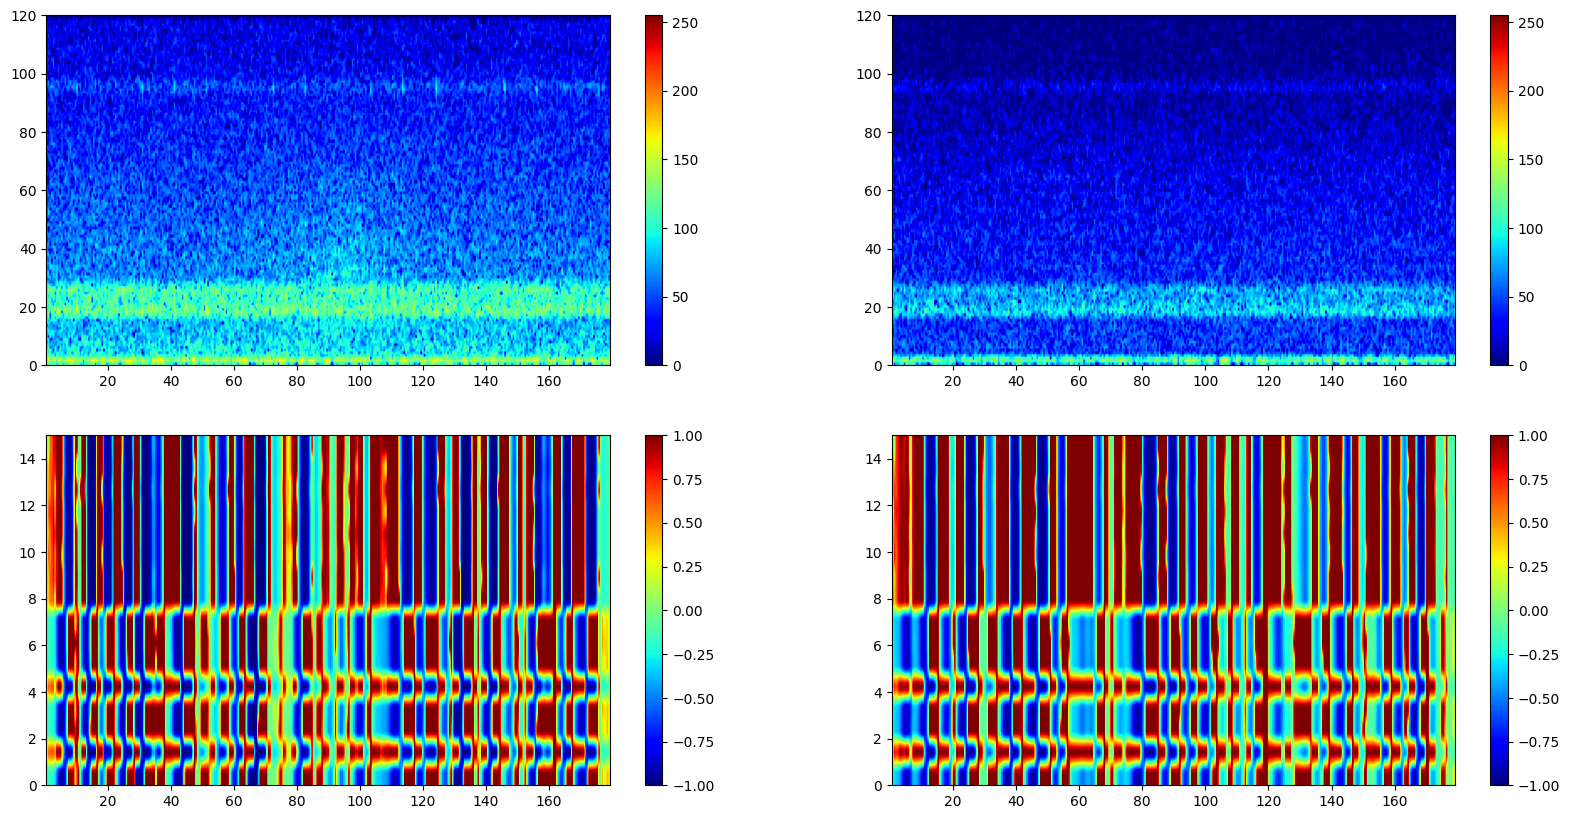

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(10*2,5*2))

im = axs[0,0].imshow(spectro, cmap="jet", aspect="auto", extent=(t[0],t[-1],f[-1],f[0]), vmin=0, vmax=255)
fig.colorbar(im)
im = axs[0,1].imshow(spectro_bis, cmap="jet", aspect="auto", extent=(t_bis[0],t_bis[-1],f_bis[-1],f_bis[0]), vmin=0, vmax=255)
fig.colorbar(im)

im = axs[1,0].imshow(res, cmap="jet", aspect="auto", extent=(t[0],t[-1],0,15), vmin=-1, vmax=1)
fig.colorbar(im)
im = axs[1,1].imshow(res_bis, cmap="jet", aspect="auto", extent=(t_bis[0],t_bis[-1],0,15), vmin=-1, vmax=1)
fig.colorbar(im)

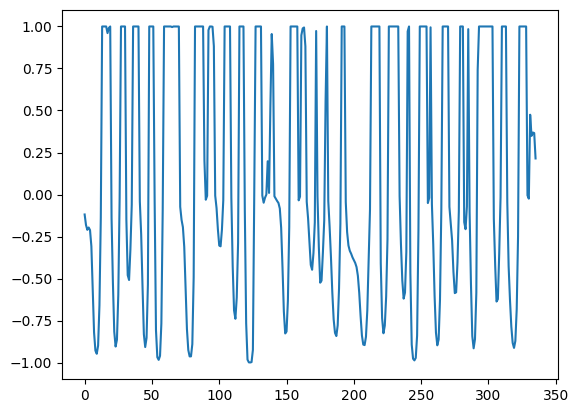

In [16]:
plt.plot(res[9,:])